### Predicting Stock Price Movement with Gradient boosting, SVMs and LSTMs 
**Goal:** The goal of this project is to create a predictive model that can forecast the directional movement of the S&P 500 with a classification accuracy moderately better than random chance (50%). While creating a perfectly accurate prediction is highly unlikely due to the complex and semi-random nature of financial markets, the goal is to develop a model that demonstrates statistically significant predictive power, providing a modest edge in forecasting market trends.

**Data Problem:** Train and tune the S&P 500 Data based on various technical indicators.

**Expected Results:** The expected results of this project is a quality model with more than 50% accuracy in predicting S&P 500 daily price movements. We will create various models and do a comparative analysis of the performance.

**Data**
Historical S&P 500 Data: Daily open, high, low, close, and volume data will be obtained using the yfinance library in Python, which pulls data from Yahoo Finance.
Macroeconomic Data: Key economic indicators such as the Federal Funds Rate, Consumer Price Index (CPI), and GDP growth rates will be sourced from the Federal Reserve Economic Data (FRED) database.

#### Import and Setup

In [372]:
import yfinance as yf
import pandas_datareader.data as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import xgboost as xgb

from ta import add_all_ta_features
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

In [373]:
# Define tickers and date range
sp500_ticker = '^GSPC'
fred_tickers = ['FEDFUNDS', 'CPIAUCNS'] # Federal Funds Rate, Consumer Price Index
start_date = '2010-01-01'
end_date = '2025-09-12'

# Fetch S&P 500 data and save it locally
if (os.path.exists('sp500_ticker_indexed.csv')):
    df = pd.read_csv('sp500_ticker_indexed.csv')
else:
    df = yf.download(sp500_ticker, start=start_date, end=end_date)
    df.to_csv('sp500_ticker_indexed.csv')

if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(0)

print(df.head())
print(df.shape)

# Fetch Macroeconomic data from FRED
if (os.path.exists('fred_tickers_indexed.csv')):
    macro_data = pd.read_csv('fred_tickers_indexed.csv')
else:
    macro_data = pdr.DataReader(fred_tickers, 'fred', start=start_date, end=end_date)
    macro_data.to_csv('fred_tickers_indexed.csv')

print(macro_data.head())
print(macro_data.shape)

        Price               Close                High                 Low  \
0      Ticker               ^GSPC               ^GSPC               ^GSPC   
1        Date                 NaN                 NaN                 NaN   
2  2010-01-04   1132.989990234375  1133.8699951171875    1116.56005859375   
3  2010-01-05    1136.52001953125  1136.6300048828125  1129.6600341796875   
4  2010-01-06  1137.1400146484375    1139.18994140625   1133.949951171875   

                 Open      Volume  
0               ^GSPC       ^GSPC  
1                 NaN         NaN  
2    1116.56005859375  3991400000  
3  1132.6600341796875  2491020000  
4     1135.7099609375  4972660000  
(3949, 6)
         DATE  FEDFUNDS  CPIAUCNS
0  2010-01-01      0.11   216.687
1  2010-02-01      0.13   216.741
2  2010-03-01      0.16   217.631
3  2010-04-01      0.20   218.009
4  2010-05-01      0.20   218.178
(189, 3)


#### Data Overview

**S&P 500:**
- Daily stock price index daily Open, Close, High, Low and Volume data
- 3949 rows / 6 columns 

**FRED**
- Monthly Federal Funds Effective Rate (FEDFUNDS) and Consumer Price Index (CPIAUCNS)
- 189 rows / 3 columns

#### Data Preparation

In [374]:
df1 = df.copy(deep = True)
df2 = macro_data.copy(deep = True)

# Clean and prepare the first DataFrame
df1 = df1.drop([0, 1])     # Drop header rows
df1 = df1.rename(columns={'Price': 'Date'})  # Match column name for merge
df1['Date'] = pd.to_datetime(df1['Date'])   # Convert to datetime
print(df1.head())

        Date               Close                High                 Low  \
2 2010-01-04   1132.989990234375  1133.8699951171875    1116.56005859375   
3 2010-01-05    1136.52001953125  1136.6300048828125  1129.6600341796875   
4 2010-01-06  1137.1400146484375    1139.18994140625   1133.949951171875   
5 2010-01-07    1141.68994140625     1142.4599609375  1131.3199462890625   
6 2010-01-08    1144.97998046875  1145.3900146484375   1136.219970703125   

                 Open      Volume  
2    1116.56005859375  3991400000  
3  1132.6600341796875  2491020000  
4     1135.7099609375  4972660000  
5    1136.27001953125  5270680000  
6    1140.52001953125  4389590000  


In [375]:
# Prepare the second DataFrame, we need to convert the monthly data into daily data
df2 = df2.rename(columns={'DATE':'Date'})
df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2.set_index('Date').resample('D').ffill().bfill().reset_index()  # Forward-fill/backward-fill daily

# Merge the two DataFrames
merged_df = pd.merge(df1, df2, on='Date', how='left')

print(merged_df.head())
print(merged_df.tail())
print(merged_df.describe())

        Date               Close                High                 Low  \
0 2010-01-04   1132.989990234375  1133.8699951171875    1116.56005859375   
1 2010-01-05    1136.52001953125  1136.6300048828125  1129.6600341796875   
2 2010-01-06  1137.1400146484375    1139.18994140625   1133.949951171875   
3 2010-01-07    1141.68994140625     1142.4599609375  1131.3199462890625   
4 2010-01-08    1144.97998046875  1145.3900146484375   1136.219970703125   

                 Open      Volume  FEDFUNDS  CPIAUCNS  
0    1116.56005859375  3991400000      0.11   216.687  
1  1132.6600341796875  2491020000      0.11   216.687  
2     1135.7099609375  4972660000      0.11   216.687  
3    1136.27001953125  5270680000      0.11   216.687  
4    1140.52001953125  4389590000      0.11   216.687  
           Date             Close              High               Low  \
3942 2025-09-05            6481.5  6532.64990234375  6443.97998046875   
3943 2025-09-08  6495.14990234375    6508.669921875   6483.29

In [376]:
# Create Target Variable
df = merged_df.copy(deep = True)
# We want to predict if the next day's price will go up (1) or down (0)
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
print(df['Target'].value_counts())
print(df['FEDFUNDS'].value_counts())
print(df.head())
df.info

Target
1    2154
0    1793
Name: count, dtype: int64
FEDFUNDS
0.09    425
0.08    332
5.33    274
4.33    185
0.16    168
       ... 
0.90     19
0.66     19
0.34     19
1.58     19
4.57     19
Name: count, Length: 75, dtype: int64
        Date               Close                High                 Low  \
0 2010-01-04   1132.989990234375  1133.8699951171875    1116.56005859375   
1 2010-01-05    1136.52001953125  1136.6300048828125  1129.6600341796875   
2 2010-01-06  1137.1400146484375    1139.18994140625   1133.949951171875   
3 2010-01-07    1141.68994140625     1142.4599609375  1131.3199462890625   
4 2010-01-08    1144.97998046875  1145.3900146484375   1136.219970703125   

                 Open      Volume  FEDFUNDS  CPIAUCNS  Target  
0    1116.56005859375  3991400000      0.11   216.687       1  
1  1132.6600341796875  2491020000      0.11   216.687       1  
2     1135.7099609375  4972660000      0.11   216.687       1  
3    1136.27001953125  5270680000      0.11   216.687  

<bound method DataFrame.info of            Date               Close                High                 Low  \
0    2010-01-04   1132.989990234375  1133.8699951171875    1116.56005859375   
1    2010-01-05    1136.52001953125  1136.6300048828125  1129.6600341796875   
2    2010-01-06  1137.1400146484375    1139.18994140625   1133.949951171875   
3    2010-01-07    1141.68994140625     1142.4599609375  1131.3199462890625   
4    2010-01-08    1144.97998046875  1145.3900146484375   1136.219970703125   
...         ...                 ...                 ...                 ...   
3942 2025-09-05              6481.5    6532.64990234375    6443.97998046875   
3943 2025-09-08    6495.14990234375      6508.669921875     6483.2900390625   
3944 2025-09-09    6512.60986328125    6518.22998046875      6483.080078125   
3945 2025-09-10     6532.0400390625    6555.97021484375       6516.33984375   
3946 2025-09-11    6587.47021484375    6592.89013671875     6545.7998046875   

                   

In [377]:
# List of columns to convert
cols_to_numeric = ['Open', 'High', 'Low', 'Close', 'Volume']

# Loop through the columns and convert them to numeric
for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.rename(columns={'Price':'Date'})
df['Date'] = pd.to_datetime(df['Date'])
df.rename(columns={'Open' : 'open', 'Close': 'close', 'High' : 'high', 'Low' : 'low', 'Volume' : 'volume'}, inplace=True)

df.info

<bound method DataFrame.info of            Date        close         high          low         open  \
0    2010-01-04  1132.989990  1133.869995  1116.560059  1116.560059   
1    2010-01-05  1136.520020  1136.630005  1129.660034  1132.660034   
2    2010-01-06  1137.140015  1139.189941  1133.949951  1135.709961   
3    2010-01-07  1141.689941  1142.459961  1131.319946  1136.270020   
4    2010-01-08  1144.979980  1145.390015  1136.219971  1140.520020   
...         ...          ...          ...          ...          ...   
3942 2025-09-05  6481.500000  6532.649902  6443.979980  6529.080078   
3943 2025-09-08  6495.149902  6508.669922  6483.290039  6498.089844   
3944 2025-09-09  6512.609863  6518.229980  6483.080078  6503.330078   
3945 2025-09-10  6532.040039  6555.970215  6516.339844  6550.290039   
3946 2025-09-11  6587.470215  6592.890137  6545.799805  6554.410156   

          volume  FEDFUNDS  CPIAUCNS  Target  
0     3991400000      0.11   216.687       1  
1     2491020000     

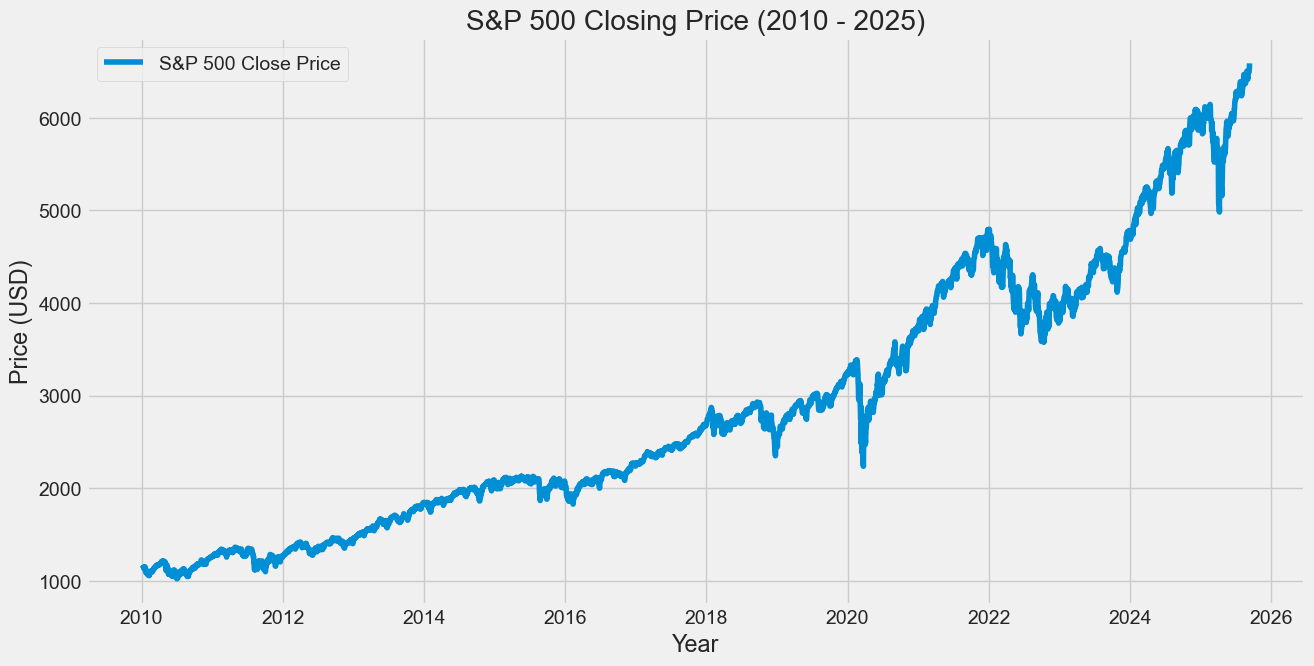

<Figure size 640x480 with 0 Axes>

In [378]:
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['close'], label='S&P 500 Close Price')
plt.title('S&P 500 Closing Price (2010 - 2025)')
plt.xlabel('Year')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()
plt.savefig('SP500_Closing_Price.png')

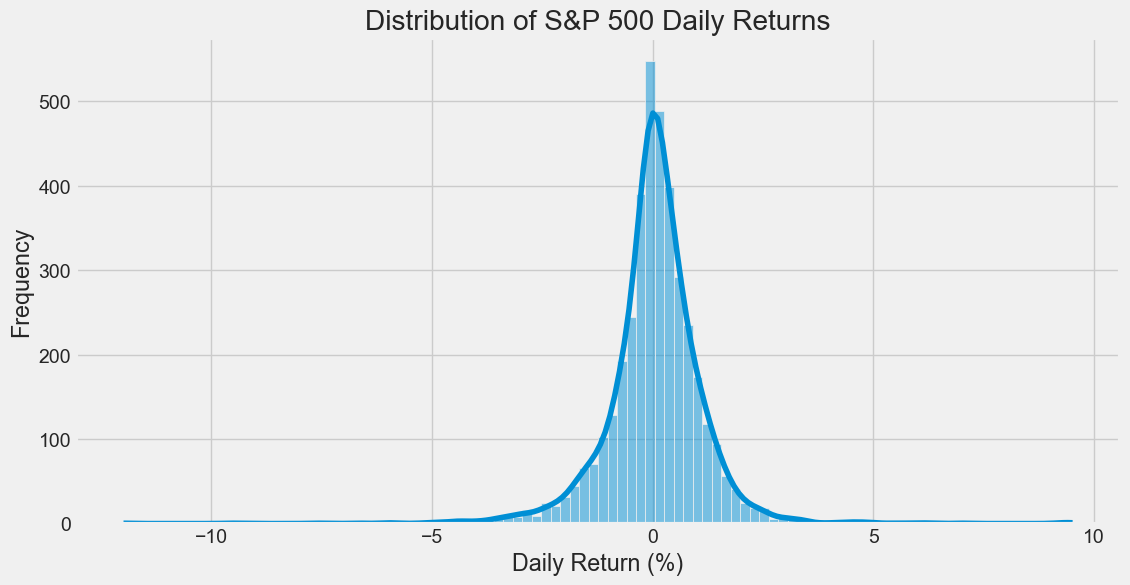

<Figure size 640x480 with 0 Axes>

In [379]:
df['Daily_Return'] = df['close'].pct_change() * 100
df.dropna(inplace=True)

plt.figure(figsize=(12, 6))
sns.histplot(df['Daily_Return'], bins=100, kde=True)
plt.title('Distribution of S&P 500 Daily Returns')
plt.xlabel('Daily Return (%)')
plt.ylabel('Frequency')
plt.show()
plt.savefig('Distribution.png')

#### Data Feature Engineering
- Collect important Technical Indicators
- Add them to the dataframe
- Final Cleaning

In [380]:
from ta.momentum import (
    RSIIndicator, StochasticOscillator, WilliamsRIndicator, AwesomeOscillatorIndicator,
    KAMAIndicator, ROCIndicator, TSIIndicator, PercentagePriceOscillator,
    UltimateOscillator
)
from ta.volume import (
    OnBalanceVolumeIndicator, ChaikinMoneyFlowIndicator, ForceIndexIndicator,
    EaseOfMovementIndicator, VolumePriceTrendIndicator, NegativeVolumeIndexIndicator,
    AccDistIndexIndicator
)
from ta.trend import (
    MACD, ADXIndicator, SMAIndicator, EMAIndicator, IchimokuIndicator,
    VortexIndicator, TRIXIndicator, MassIndex, KSTIndicator
)

def add_ta_features(df):
    # Momentum Indicators
    df['rsi'] = RSIIndicator(df['close']).rsi()
    df['stoch'] = StochasticOscillator(df['high'], df['low'], df['close']).stoch()
    df['williams_r'] = WilliamsRIndicator(df['high'], df['low'], df['close']).williams_r()
    df['ao'] = AwesomeOscillatorIndicator(df['high'], df['low']).awesome_oscillator()
    df['kama'] = KAMAIndicator(df['close']).kama()
    df['roc'] = ROCIndicator(df['close']).roc()
    df['tsi'] = TSIIndicator(df['close']).tsi()
    df['ppo'] = PercentagePriceOscillator(df['close']).ppo()
    df['ultimate'] = UltimateOscillator(df['high'], df['low'], df['close']).ultimate_oscillator()

    # Volume Indicators
    df['obv'] = OnBalanceVolumeIndicator(df['close'], df['volume']).on_balance_volume()
    df['cmf'] = ChaikinMoneyFlowIndicator(df['high'], df['low'], df['close'], df['volume']).chaikin_money_flow()
    df['force'] = ForceIndexIndicator(df['close'], df['volume']).force_index()
    df['vpt'] = VolumePriceTrendIndicator(df['close'], df['volume']).volume_price_trend()
    df['nvi'] = NegativeVolumeIndexIndicator(df['close'], df['volume']).negative_volume_index()
    df['adi'] = AccDistIndexIndicator(df['high'], df['low'], df['close'], df['volume']).acc_dist_index()

    # Trend Indicators
    macd = MACD(df['close'])
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    df['adx'] = ADXIndicator(df['high'], df['low'], df['close']).adx()
    df['sma'] = SMAIndicator(df['close'], window=20).sma_indicator()
    df['ema'] = EMAIndicator(df['close'], window=20).ema_indicator()
    vortex = VortexIndicator(df['high'], df['low'], df['close'])
    df['vortex_pos'] = vortex.vortex_indicator_pos()
    df['vortex_neg'] = vortex.vortex_indicator_neg()
    df['trix'] = TRIXIndicator(df['close']).trix()
    df['mass_index'] = MassIndex(df['high'], df['low']).mass_index()
    df['kst'] = KSTIndicator(df['close']).kst()

    df.dropna(inplace=True)
    # features = df.drop(columns=['open', 'high', 'low', 'close', 'volume'])

    return df

In [381]:
df = add_ta_features(df)
print("Features engineered. New shape:", df.shape)
print(df.head())
df.info()

Features engineered. New shape: (3895, 35)
         Date        close         high          low         open      volume  \
44 2010-03-09  1140.449951  1145.369995  1134.900024  1137.560059  5185570000   
45 2010-03-10  1145.609985  1148.260010  1140.089966  1140.219971  5469120000   
46 2010-03-11  1150.239990  1150.239990  1138.989990  1143.959961  4669060000   
47 2010-03-12  1149.989990  1153.410034  1146.969971  1151.709961  4928160000   
48 2010-03-15  1150.510010  1150.979980  1141.449951  1148.530029  4164110000   

    FEDFUNDS  CPIAUCNS  Target  Daily_Return  ...       macd  macd_signal  \
44      0.16   217.631       1      0.171274  ...   8.810257     3.202438   
45      0.16   217.631       1      0.452456  ...  10.148751     4.591701   
46      0.16   217.631       0      0.404152  ...  11.451118     5.963584   
47      0.16   217.631       1     -0.021735  ...  12.321051     7.235077   
48      0.16   217.631       1      0.045219  ...  12.903695     8.368801   

       

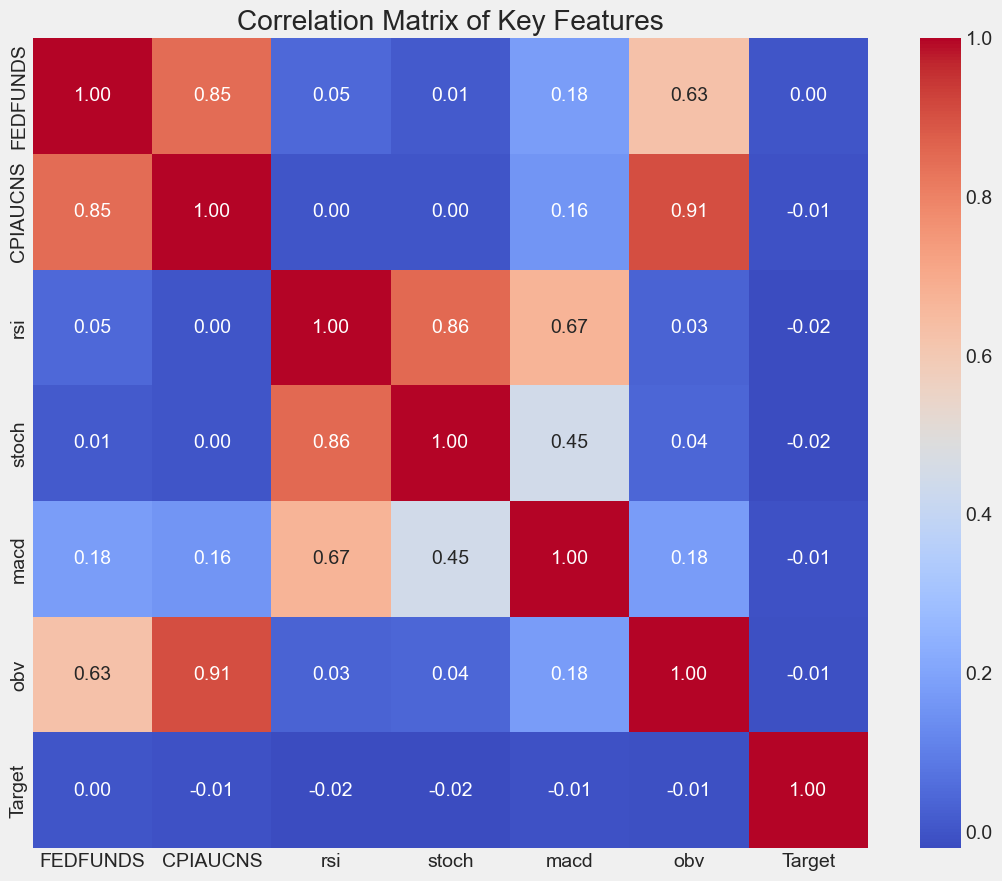

<Figure size 640x480 with 0 Axes>

In [382]:
# Select a subset of key features for a cleaner heatmap
features_for_corr = [
    'FEDFUNDS', 'CPIAUCNS', 'rsi', 'stoch', 'macd', 'obv', 'Target'
]

plt.figure(figsize=(12, 10))
sns.heatmap(df[features_for_corr].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Key Features')
plt.show()
plt.savefig('Correlation_Matrix.png')

In [383]:
# Make sure the main DataFrame's index is the date
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

features = df.drop(['Target', 'Daily_Return'], axis=1)
target = df['Target']
print(features.head())
features.describe()

# Chronological Data Split
print("Splitting data...")
split_date = '2024-06-01'

X_train = features.loc[features.index < split_date]
X_test = features.loc[features.index >= split_date]
y_train = target.loc[target.index < split_date]
y_test = target.loc[target.index >= split_date]

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

                  close         high          low         open      volume  \
Date                                                                         
2010-03-09  1140.449951  1145.369995  1134.900024  1137.560059  5185570000   
2010-03-10  1145.609985  1148.260010  1140.089966  1140.219971  5469120000   
2010-03-11  1150.239990  1150.239990  1138.989990  1143.959961  4669060000   
2010-03-12  1149.989990  1153.410034  1146.969971  1151.709961  4928160000   
2010-03-15  1150.510010  1150.979980  1141.449951  1148.530029  4164110000   

            FEDFUNDS  CPIAUCNS        rsi       stoch  williams_r  ...  \
Date                                                               ...   
2010-03-09      0.16   217.631  66.731396   91.710116   -8.289884  ...   
2010-03-10      0.16   217.631  68.615032   95.742248   -4.257752  ...   
2010-03-11      0.16   217.631  70.243069  100.000000   -0.000000  ...   
2010-03-12      0.16   217.631  70.031826   94.924999   -5.075001  ...   
2010-03-1

### Baseline Model : Logistic Regression
- We will use Logistic Regression as a baseline model. It models the relationship between the dependent variable and the independent variables using a logistic function, which outputs values between 0 and 1, indicating the likelihood of a particular event occurring.

In [384]:
# Scale the Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train and Evaluate the Model
model = LogisticRegression(random_state=42, max_iter = 1000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nBaseline Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Down', 'Up']))


Baseline Model Accuracy: 0.4679

Classification Report:
              precision    recall  f1-score   support

        Down       0.43      0.68      0.52       134
          Up       0.56      0.31      0.40       178

    accuracy                           0.47       312
   macro avg       0.49      0.49      0.46       312
weighted avg       0.50      0.47      0.45       312



We observe that the baseline model has an accuracy of 0.4679

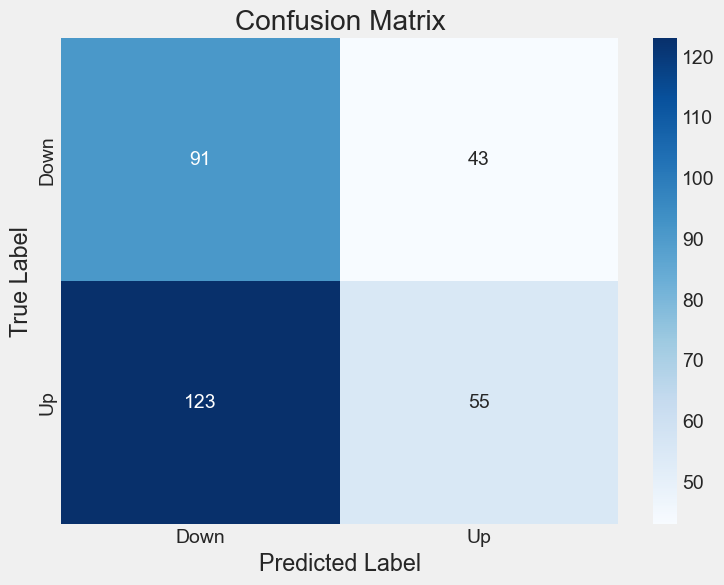

<Figure size 640x480 with 0 Axes>

In [385]:
# Visualize the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
plt.savefig('Confustion_Matrix.png')

### Model 2 : Gradient Boosting
- We will use Gradient Boosting (xgboost) as the second model. This implements a gradient boosting framework that combines multiple weak models, specifically decision trees, to create a strong predictive model.

In [386]:
# Initialize and Train the Model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

print("Training XGBoost model...")
xgb_model.fit(X_train_scaled, y_train)

# Evaluate the Model
print("\nXGBoost Model Evaluation:")
y_pred_xgb = xgb_model.predict(X_test_scaled)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print(f"Accuracy: {accuracy_xgb:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Down', 'Up']))

Training XGBoost model...

XGBoost Model Evaluation:
Accuracy: 0.4583

Classification Report:
              precision    recall  f1-score   support

        Down       0.42      0.67      0.52       134
          Up       0.55      0.30      0.39       178

    accuracy                           0.46       312
   macro avg       0.48      0.48      0.45       312
weighted avg       0.49      0.46      0.44       312



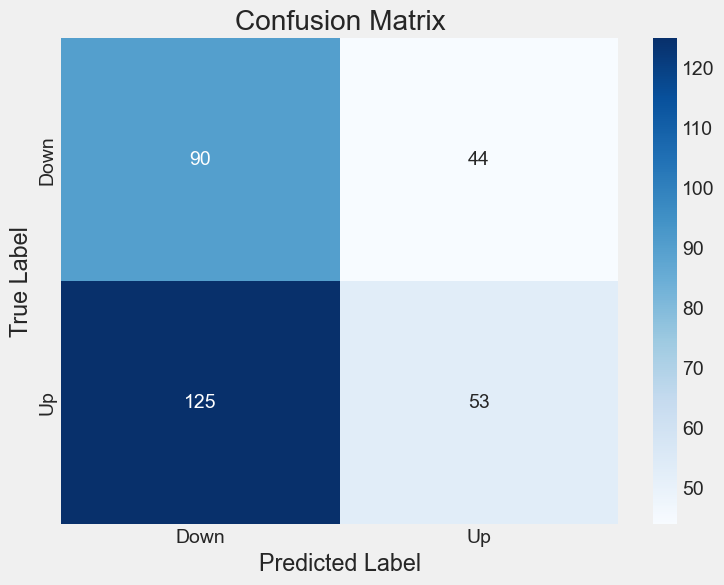

<Figure size 640x480 with 0 Axes>

In [387]:
# Visualize the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
plt.savefig('Confustion_Matrix_xgb.png')

We observe that gradient bossting model has an accuracy of 0.4583 which is less than baseline.

### Model 3 : Support Vector Classifier
- The third model we consider is SVC. It works by finding the best hyperplane that separates different classes in high-dimensional space, maximizing the margin between the classes.

In [388]:
# Initialize and Train the Model
svm_model = SVC(kernel='rbf', random_state=42)

print("Training SVM model...")
svm_model.fit(X_train_scaled, y_train)

# Evaluate the Model
print("\nSVM Model Evaluation:")
y_pred_svm = svm_model.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print(f"Accuracy: {accuracy_svm:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['Down', 'Up']))

Training SVM model...

SVM Model Evaluation:
Accuracy: 0.5513

Classification Report:
              precision    recall  f1-score   support

        Down       0.45      0.20      0.28       134
          Up       0.58      0.81      0.67       178

    accuracy                           0.55       312
   macro avg       0.51      0.51      0.48       312
weighted avg       0.52      0.55      0.50       312



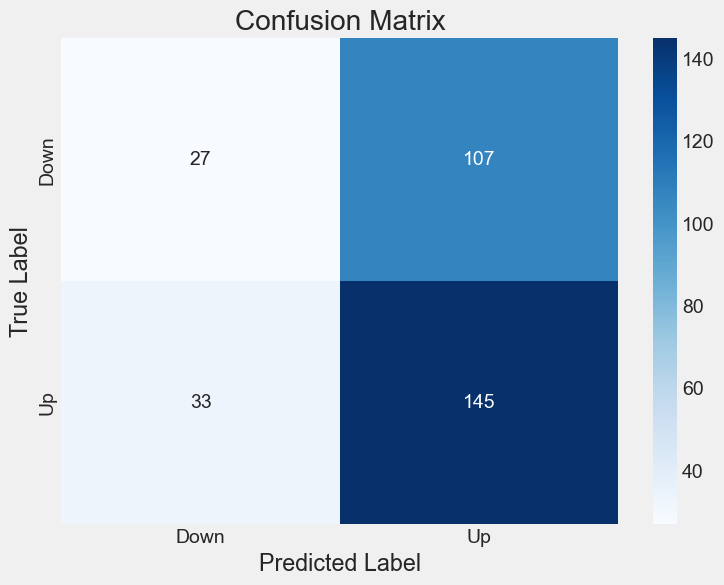

<Figure size 640x480 with 0 Axes>

In [389]:
# Visualize the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
plt.savefig('Confustion_Matrix_SVC.png')

We observe that the SVC model has an accuracy of 0.5513 which is more than baseline and also meets the expectations for the outcome of this project.

### Model 4 : Decision Trees
- The next model is Decision Trees. It uses a non-parametric supervised learning algorithm, which is utilized for both classification and regression tasks.

In [390]:
# Initialize and Train the Model
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)

print("Training Decision Tree model")
dt_model.fit(X_train_scaled, y_train)

# --- 2. Evaluate the Model ---
print("\nDecision Tree Model Evaluation:")
y_pred_dt = dt_model.predict(X_test_scaled)
accuracy_dt = accuracy_score(y_test, y_pred_dt)

print(f"Accuracy: {accuracy_dt:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt, target_names=['Down', 'Up']))

Training Decision Tree model

Decision Tree Model Evaluation:
Accuracy: 0.5256

Classification Report:
              precision    recall  f1-score   support

        Down       0.46      0.64      0.54       134
          Up       0.62      0.44      0.51       178

    accuracy                           0.53       312
   macro avg       0.54      0.54      0.53       312
weighted avg       0.55      0.53      0.52       312



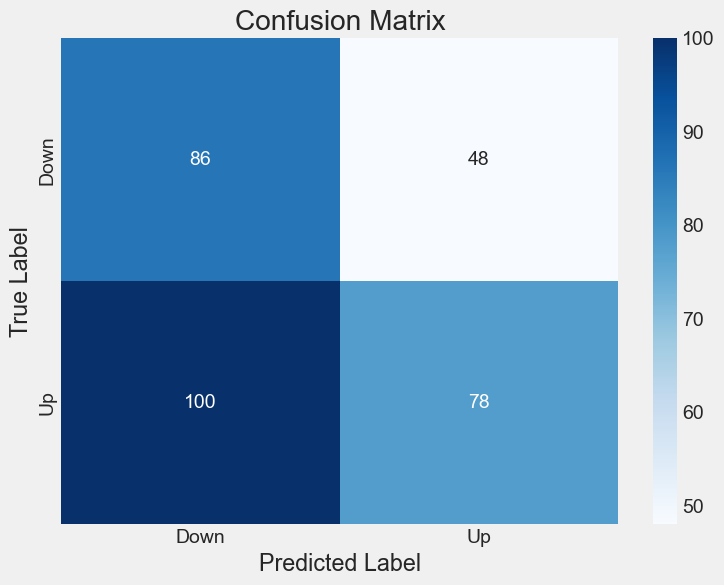

<Figure size 640x480 with 0 Axes>

In [391]:
# Visualize the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
plt.savefig('Confustion_Matrix_DecistionTree.png')

We observe that the Decision Tree model achieves an accuracy of 0.5256 which is more than baseline but not as good as SVC. It has however a better precision than SVC.

### Model 5 : Long Short Term Memory
- The last model we will consider is LSTM. LSTMs can capture long-term dependencies in sequential data making them ideal for tasks
  like language translation, speech recognition and time series forecasting.

In [392]:
def create_sequences(X, y, timesteps=10):
    """
    Reshapes data into 3D format for LSTM.
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        X_seq.append(X[i:(i + timesteps)])
        y_seq.append(y[i + timesteps])
    return np.array(X_seq), np.array(y_seq)

# Define the number of timesteps
TIMESTEPS = 10

# Create sequences from the training and testing data
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, TIMESTEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, TIMESTEPS)

print(f"Shape of X_train_seq: {X_train_seq.shape}") # (samples, timesteps, features)
print(f"Shape of y_train_seq: {y_train_seq.shape}")

Shape of X_train_seq: (3573, 10, 32)
Shape of y_train_seq: (3573,)


In [393]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=25, activation='relu'))
lstm_model.add(Dense(units=1, activation='sigmoid')) # Sigmoid for binary classification

# Compile the model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.summary()

# Train the Model
print("\nTraining LSTM model...")
history = lstm_model.fit(
    X_train_seq,
    y_train_seq,
    epochs=20,
    batch_size=32,
    validation_split=0.1, # Use part of training data for validation
    verbose=1
)

# Evaluate the Model
print("\nLSTM Model Evaluation:")
# Predict probabilities
y_pred_prob_lstm = lstm_model.predict(X_test_seq)
# Convert probabilities to binary classes (0 or 1)
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype(int)

accuracy_lstm = accuracy_score(y_test_seq, y_pred_lstm)
print(f"Accuracy: {accuracy_lstm:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_seq, y_pred_lstm, target_names=['Down', 'Up']))

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_36 (LSTM)                  │ (None, 10, 50)         │        16,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,101 (148.83 KB)

 Trainable params: 38,101 (148.83 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM model...
Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.5235 - loss: 0.6923 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5418 - loss: 0.6896 - val_accuracy: 0.4525 - val_loss: 0.7021
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5434 - loss: 0.6886 - val_accuracy: 0.4916 - val_loss: 0.7017
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5400 - loss: 0.6898 - val_accuracy: 0.5028 - val_loss: 0.7024
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5418 - loss: 0.6880 - val_accuracy: 0.4553 - val_loss: 0.7231
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5561 - loss: 0.6869 - val_accuracy: 0.4525 - val_loss: 0.7389
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5484 - loss: 0.6861 - val_accuracy: 0.5000 - val_loss: 0.6952
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5533 

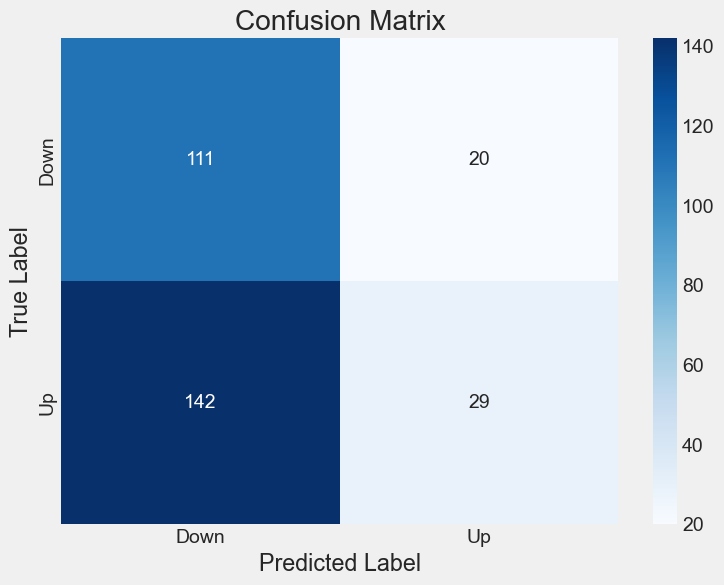

<Figure size 640x480 with 0 Axes>

In [394]:
# Visualize the Confusion Matrix
cm = confusion_matrix(y_test_seq, y_pred_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
plt.savefig('Confustion_Matrix_LSTM.png')

We observe that this LSTM model has an accuracy of 0.46 which is lower than baseline.

Hence, we conclude that SVC is the best model for predicting stock price movement with this dataset as it has the best accuracy of 0.5513. Decision Trees are the second best and has a higher precision than SVC.

|Model|Accuracy|Precision|Recall|F1-Score|
|-----|--------|---------|------|--------|
|LogisticRegression|0.47|0.50|0.47|0.45|
|GradientBoosting|0.46|0.49|0.46|0.44|
|SVC|0.55|0.52|0.55|0.50|
|DecisionTree|0.53|0.55|0.53|0.52|
|LSTM|0.46|0.53|0.46|0.40|